# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [3]:
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers

In [4]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned
from zotbin.optimize import *

In [5]:
zedges, fedges, grpidw, zhistw, zsimw = load_groups('groups_20_120_200.npz')

In [6]:
#zedges, fedges, grpidw4, zhistw4, zsimw4 = load_groups('groups_20_120_400.npz')

In [7]:
#zedges, fedges, grpidn, zhistn, zsimn = load_groups('groups_20_120_200_nowgt.npz')

In [8]:
init_data = load_binned('binned_40.npz')

In [9]:
assert (len(zedges) - 1) % (len(init_data[0]) - 1) == 0
downsampling = (len(zedges) - 1) // (len(init_data[0]) - 1)
print(f'Downsampling by {downsampling}')

Downsampling by 3


Calculate the normalized dndz for the DC2 and Buzzard datasets using the downsampled binning:

In [10]:
from tomo_challenge import load_redshift

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [11]:
zds = np.asarray(init_data[0])

In [12]:
zdc2 = load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')
zbuz = load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')

In [13]:
dndz_dc2, _ = np.histogram(zdc2, zds)
dndz_dc2 = dndz_dc2 / dndz_dc2.sum()

In [14]:
dndz_buz, _ = np.histogram(zbuz, zds)
dndz_buz = dndz_buz / dndz_buz.sum()

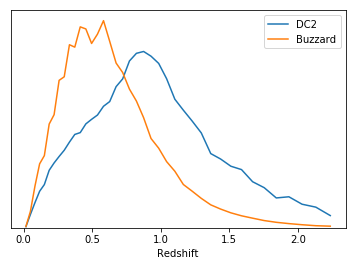

In [15]:
zc = 0.5 * (zds[1:] + zds[:-1])
plt.plot(zc, dndz_dc2, label='DC2')
plt.plot(zc, dndz_buz, label='Buzzard')
plt.xlabel('Redshift')
plt.yticks([])
plt.ylim(0, None)
plt.legend();

In [16]:
p0 = np.random.normal(size=(2, 40))

In [20]:
max_score, pf, scores = jax_optimize(optimizers.sgd(1.), p0, 100, softmax_transform, jnp.diag(dndz_buz), init_data)

In [23]:
metrics(pf, softmax_transform, jnp.diag(dndz_buz), init_data, 20., 0.25)

{'FOM_3x2': DeviceArray(756.46313, dtype=float32),
 'FOM_DETF_3x2': DeviceArray(22.39857, dtype=float32),
 'SNR_3x2': DeviceArray(892.4441, dtype=float32)}

In [21]:
max_score

22.39619255065918

In [17]:
max_score, pf, scores = scipy_optimize(
    dict(method='BFGS', options=dict(maxiter=500, gtol=1e-4, disp=False)),
    p0, softmax_transform, jnp.diag(dndz_buz), init_data)

In [18]:
metrics(pf, softmax_transform, jnp.diag(dndz_buz), init_data, 20., 0.25)

{'FOM_3x2': DeviceArray(473.26242, dtype=float32),
 'FOM_DETF_3x2': DeviceArray(20.831272, dtype=float32),
 'SNR_3x2': DeviceArray(934.4666, dtype=float32)}

In [19]:
max_score

20.83127212524414

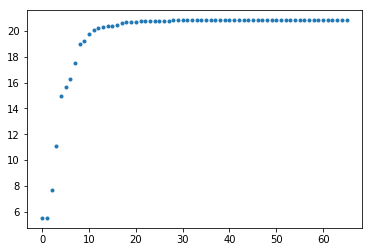

In [20]:
plt.plot(scores, '.')

In [18]:
def train(weight_shape, get_weights, ntrial, niter, eta, gamma, decay=1., seed=123, print_interval=50, bfgs_init=False, bfgs_final=True,
          plot=True, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):

    @jax.jit
    def score(p):
        w = get_weights(p.reshape(weight_shape))
        weights = jnp.array([w,  w])
        return reweighted_metrics(
            weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky)[metric]
    
    score_and_grads = jax.jit(jax.value_and_grad(score))
    
    scale = 2
    def optimize_fun(p):
        value, grad = value_and_score(jnp.array(p))
        return -scale * np.float(value), -scale * np.array(grad)

    # Calculate the decay factor required to attenuate the learning rate over niter.
    if niter > 0:
        alpha = decay ** (1 / niter)
    
    scores = np.empty((ntrial, niter))
    gen = np.random.RandomState(seed)
    max_score = 0
    pbest = None
    for itrial in range(ntrial):
        # Random weight initialization.
        p = gen.normal(scale=1., size=weight_shape).reshape(-1)
        if bfgs_init:
            # Do initial optimization using scipy.
            R = scipy.optimize.minimize(
                optimize_fun, p, method='BFGS', jac=True,
                options=dict(maxiter=500, gtol=1e-5, disp=False))
            score = -R.fun / scale
            p = R.x
            if score > max_score:
                pbest = jnp.array(p)
                max_score = score
            print(f'trial {itrial+1}/{ntrial} initial BFGS score {score:.3f} status {R.status} max {max_score:.3f}')
        # Optimize gradient descent.
        p = jnp.array(p)
        dplast = jnp.zeros_like(p)
        for it in range(niter):
            score, grads = value_and_score(p)
            scores[itrial, it] = float(score)
            if scores[itrial, it] > max_score:
                pbest = jnp.array(p)
                max_score = scores[itrial, it]
            dp = eta * grads + gamma * dplast
            eta *= alpha
            p += dp
            dplast = dp
            if it == 0 or (it + 1) % print_interval == 0:
                print(f'trial {itrial+1}/{ntrial} iteration {it+1}/{niter} score {scores[itrial, it]:.3f} max {max_score:.3f}')

    if bfgs_final and pbest is not None:
        # Refine the best result so far using scipy.
        p = np.array(pbest)
        R = scipy.optimize.minimize(
            optimize_fun, p, method='BFGS', jac=True,
            options=dict(maxiter=500, gtol=1e-5, disp=False))
        score = -R.fun / scale
        print(f'final BFGS score {score:.3f} status {R.status}')
        if score > max_score:
            max_score = score
            pbest = jnp.array(R.x)

    wbest = np.array(get_weights(pbest.reshape(weight_shape))) if pbest is not None else None

    if plot and wbest is not None:
        print(f'Max score: {max_score:.3f}.')
        plt.plot(scores.T)
        plt.xlabel('Iteration')
        plt.ylabel(metric)
        plt.show()
        ze = init_data[0]
        zc = 0.5 * (ze[1:] + ze[:-1])
        for i in range(len(wbest)):
            plt.hist(zc, ze, weights=wbest[i], alpha=0.4, histtype='stepfilled')
    
    return wbest, max_score

Optimize weighs using true redshifts as input:

In [15]:
def optimize_truez(dndz, nbin=2, ntrial=5, niter=100, eta=2., gamma=0.1, decay=0.5):

    dndz = jnp.array(dndz)
    dndz /= dndz.sum()
    
    @jax.jit
    def get_weights(p):
        w = jnp.exp(p)
        return w / w.sum(axis=0) * dndz
    
    return train((nbin, len(dndz)), get_weights, ntrial, niter, eta, gamma, decay)

In [16]:
def optimize_truez_new(dndz, nbin=2, ntrial=5, niter=100, eta=2., gamma=0.1, decay=0.5):

    dndz = jnp.array(dndz)
    dndz /= dndz.sum()
    
    @jax.jit
    def get_weights(p):
        return dndz * normalized_columns(p)
    
    return train((nbin - 1, len(dndz)), get_weights, ntrial, niter, eta, gamma, decay, bfgs_final=False)

trial 1/2 iteration 1/100 score 6.571 max 6.571
trial 1/2 iteration 50/100 score 21.894 max 21.894
trial 1/2 iteration 100/100 score 22.418 max 22.418
trial 2/2 iteration 1/100 score 1.839 max 22.418
trial 2/2 iteration 50/100 score 20.763 max 22.418
trial 2/2 iteration 100/100 score 21.730 max 22.418
Max score: 22.418.


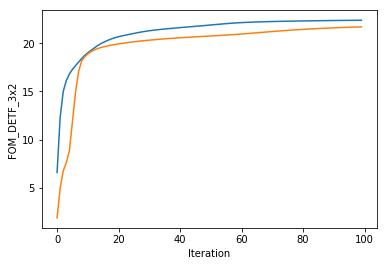

CPU times: user 2.47 s, sys: 145 ms, total: 2.62 s
Wall time: 2.43 s


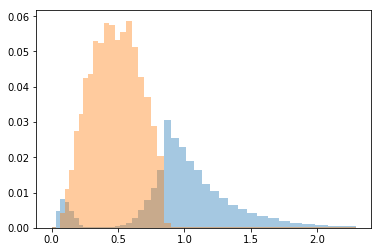

In [20]:
%time results = optimize_truez_new(dndz_buz, ntrial=2, niter=100, nbin=2)

trial 1/2 iteration 1/100 score 6.571 max 6.571
trial 1/2 iteration 50/100 score 21.895 max 21.895
trial 1/2 iteration 100/100 score 22.417 max 22.417
trial 2/2 iteration 1/100 score 1.846 max 22.417
trial 2/2 iteration 50/100 score 20.763 max 22.417
trial 2/2 iteration 100/100 score 21.730 max 22.417
Max score: 22.417.


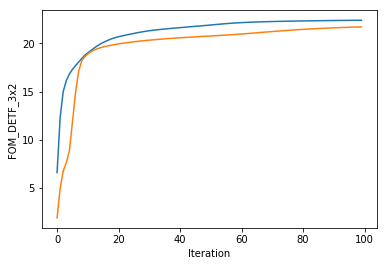

CPU times: user 5.28 s, sys: 234 ms, total: 5.52 s
Wall time: 5.3 s


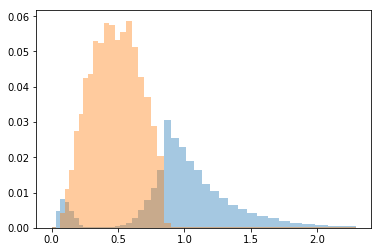

In [51]:
%time results = optimize_truez_new(dndz_buz, ntrial=2, niter=100, nbin=2)

trial 1/1 initial BFGS score 21.948 status 2
trial 1/1 iteration 1/500 score 21.948 max 21.948
trial 1/1 iteration 50/500 score 21.952 max 21.952
trial 1/1 iteration 100/500 score 21.956 max 21.958
trial 1/1 iteration 150/500 score 21.963 max 21.963
trial 1/1 iteration 200/500 score 21.973 max 21.973
trial 1/1 iteration 250/500 score 21.978 max 21.978
trial 1/1 iteration 300/500 score 21.979 max 21.979
trial 1/1 iteration 350/500 score 21.979 max 21.980
trial 1/1 iteration 400/500 score 21.979 max 21.981
trial 1/1 iteration 450/500 score 21.980 max 21.981
trial 1/1 iteration 500/500 score 21.980 max 21.981
final BFGS score 21.981 status 2
Max score: 21.981.


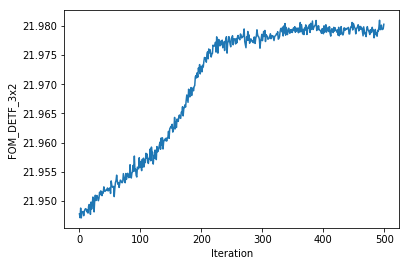

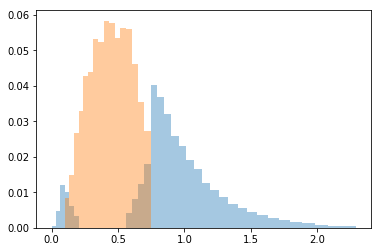

In [233]:
results = optimize_truez_new(dndz_buz, ntrial=1, niter=500, nbin=2)

trial 1/10 iteration 1/500 score 6.571 max 6.571
trial 1/10 iteration 50/500 score 22.112 max 22.112
trial 1/10 iteration 100/500 score 22.517 max 22.517
trial 1/10 iteration 150/500 score 22.679 max 22.680
trial 1/10 iteration 200/500 score 22.715 max 22.716
trial 1/10 iteration 250/500 score 22.734 max 22.735
trial 1/10 iteration 300/500 score 22.746 max 22.746
trial 1/10 iteration 350/500 score 22.755 max 22.755
trial 1/10 iteration 400/500 score 22.761 max 22.761
trial 1/10 iteration 450/500 score 22.764 max 22.766
trial 1/10 iteration 500/500 score 22.768 max 22.769
trial 2/10 iteration 1/500 score 1.839 max 22.769
trial 2/10 iteration 50/500 score 20.921 max 22.769
trial 2/10 iteration 100/500 score 21.989 max 22.769
trial 2/10 iteration 150/500 score 22.256 max 22.769
trial 2/10 iteration 200/500 score 22.554 max 22.769
trial 2/10 iteration 250/500 score 22.639 max 22.769
trial 2/10 iteration 300/500 score 22.673 max 22.769
trial 2/10 iteration 350/500 score 22.693 max 22.769
tr

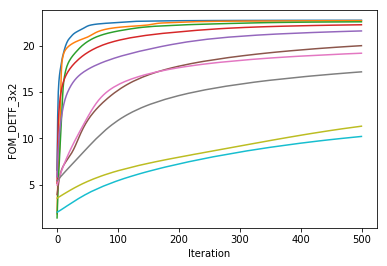

CPU times: user 17.7 s, sys: 1.45 s, total: 19.2 s
Wall time: 15.9 s


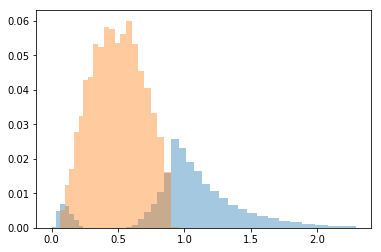

In [21]:
%time results = optimize_truez_new(dndz_buz, ntrial=10, niter=500, nbin=2)

trial 1/10 iteration 1/500 score 6.570 max 6.570
trial 1/10 iteration 50/500 score 22.113 max 22.113
trial 1/10 iteration 100/500 score 22.517 max 22.517
trial 1/10 iteration 150/500 score 22.679 max 22.680
trial 1/10 iteration 200/500 score 22.716 max 22.716
trial 1/10 iteration 250/500 score 22.735 max 22.735
trial 1/10 iteration 300/500 score 22.747 max 22.747
trial 1/10 iteration 350/500 score 22.753 max 22.755
trial 1/10 iteration 400/500 score 22.761 max 22.761
trial 1/10 iteration 450/500 score 22.765 max 22.765
trial 1/10 iteration 500/500 score 22.767 max 22.768
trial 2/10 iteration 1/500 score 1.840 max 22.768
trial 2/10 iteration 50/500 score 20.921 max 22.768
trial 2/10 iteration 100/500 score 21.990 max 22.768
trial 2/10 iteration 150/500 score 22.257 max 22.768
trial 2/10 iteration 200/500 score 22.555 max 22.768
trial 2/10 iteration 250/500 score 22.639 max 22.768
trial 2/10 iteration 300/500 score 22.673 max 22.768
trial 2/10 iteration 350/500 score 22.693 max 22.768
tr

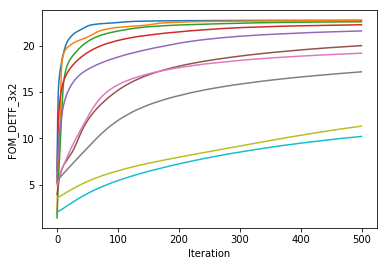

CPU times: user 1min 19s, sys: 2 s, total: 1min 21s
Wall time: 1min 18s


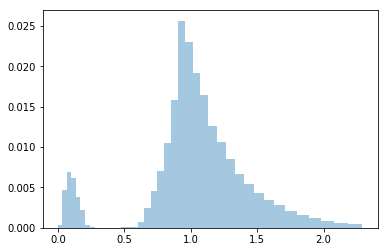

In [223]:
%time results = optimize_truez_new(dndz_buz, ntrial=10, niter=500, nbin=2)

trial 1/10 iteration 1/500 score 4.811 max 4.811
trial 1/10 iteration 50/500 score 22.157 max 22.407
trial 1/10 iteration 100/500 score 22.388 max 22.696
trial 1/10 iteration 150/500 score 22.226 max 22.714
trial 1/10 iteration 200/500 score 22.724 max 22.762
trial 1/10 iteration 250/500 score 22.662 max 22.763
trial 1/10 iteration 300/500 score 22.700 max 22.763
trial 1/10 iteration 350/500 score 22.730 max 22.763
trial 1/10 iteration 400/500 score 22.754 max 22.763
trial 1/10 iteration 450/500 score 22.781 max 22.781
trial 1/10 iteration 500/500 score 22.788 max 22.789
trial 2/10 iteration 1/500 score 3.397 max 22.789
trial 2/10 iteration 50/500 score 22.040 max 22.789
trial 2/10 iteration 100/500 score 22.496 max 22.789
trial 2/10 iteration 150/500 score 22.675 max 22.789
trial 2/10 iteration 200/500 score 22.715 max 22.789
trial 2/10 iteration 250/500 score 22.736 max 22.789
trial 2/10 iteration 300/500 score 22.747 max 22.789
trial 2/10 iteration 350/500 score 22.754 max 22.789
tr

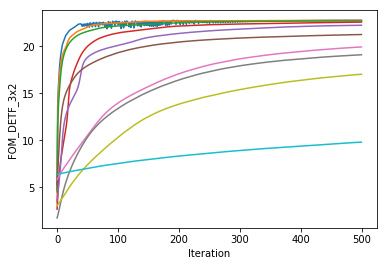

CPU times: user 1min 19s, sys: 1.65 s, total: 1min 21s
Wall time: 1min 17s


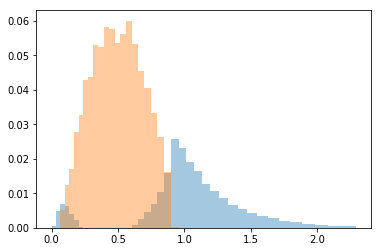

In [185]:
%time results = optimize_truez(dndz_buz, ntrial=10, niter=500, nbin=2)

trial 1/2 iteration 1/200 score 4.811 max 4.811
trial 1/2 iteration 50/200 score 22.177 max 22.177
trial 1/2 iteration 100/200 score 22.635 max 22.635
trial 1/2 iteration 150/200 score 22.705 max 22.705
trial 1/2 iteration 200/200 score 22.734 max 22.734
trial 2/2 iteration 1/200 score 3.397 max 22.734
trial 2/2 iteration 50/200 score 22.089 max 22.734
trial 2/2 iteration 100/200 score 22.517 max 22.734
trial 2/2 iteration 150/200 score 22.695 max 22.734
trial 2/2 iteration 200/200 score 22.729 max 22.734
final BFGS score 22.805 status 2
Max score: 22.805.


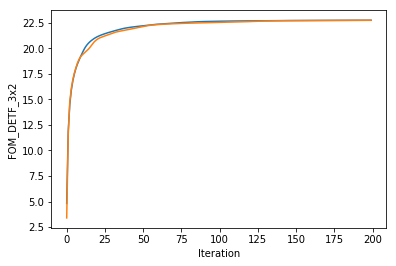

CPU times: user 23.7 s, sys: 367 ms, total: 24 s
Wall time: 11.7 s


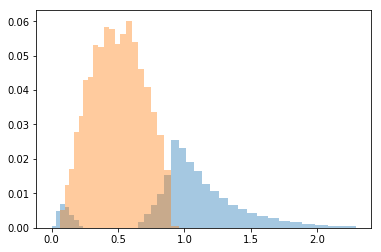

In [171]:
%time results = optimize_truez(dndz_buz, ntrial=2, niter=200, nbin=2, eta=1.0)

trial 1/5 score 47.910
trial 2/5 score 46.821
trial 3/5 failed with score 50.626: Desired error not necessarily achieved due to precision loss.
trial 4/5 failed with score nan: Desired error not necessarily achieved due to precision loss.
trial 5/5 score 52.069
Max score: 52.069.
CPU times: user 4min 14s, sys: 4.43 s, total: 4min 19s
Wall time: 51.5 s


(array([[3.83125473e-04, 4.75511793e-03, 1.21306712e-02, 1.85666867e-02,
         2.97082048e-09, 1.13003135e-10, 6.75404561e-04, 1.48768242e-09,
         2.75174631e-12, 1.92027368e-19, 1.62348899e-15, 2.82918080e-07,
         1.26960569e-11, 2.09285592e-13, 6.19494803e-11, 3.43926060e-15,
         8.45149834e-16, 1.35240614e-12, 1.67140641e-07, 9.54658463e-10,
         1.18445823e-10, 3.73283755e-22, 8.42146530e-09, 7.86037554e-11,
         4.73984730e-14, 7.49772553e-12, 7.84576404e-09, 2.88078119e-24,
         3.98661215e-10, 2.68479905e-08, 5.45518297e-10, 1.12858224e-07,
         3.46809207e-03, 2.16996838e-07, 7.49944491e-07, 2.76926289e-06,
         8.60678085e-07, 8.84246372e-04, 6.12845761e-05, 4.93399602e-05],
        [1.82767597e-08, 6.17164534e-22, 9.96476615e-21, 6.12667783e-09,
         1.77140961e-07, 1.27618012e-12, 3.28397476e-10, 6.19881533e-13,
         1.77192686e-14, 4.10242292e-11, 2.56000110e-10, 6.30520205e-08,
         1.89697298e-14, 1.15260322e-14, 4.8606548

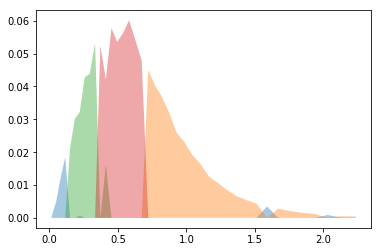

In [123]:
%time result = optimize_truez(dndz_buz, nbin=4, niter=1000);

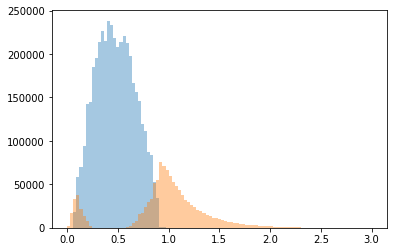

In [76]:
labels2 = get_labels(zbuz, wbest2)
plot_labels(zbuz, labels2)
np.save('buzzard_labels2.npy', labels2.astype(np.uint8))

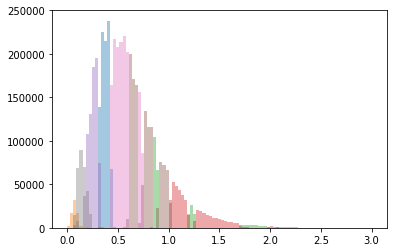

In [74]:
labels8 = get_labels(zbuz, wbest8)
plot_labels(zbuz, labels8)
np.save('buzzard_labels8.npy', labels8.astype(np.uint8))

Optimize weights using feature space groups:

In [186]:
def optimize_bins(zhist, nbin=2, ntrial=5, niter=100, eta=1., gamma=0.1, decay=1.0):

    ngrp, nzbin = zhist.shape
    nds = len(init_data[0]) - 1
    assert nzbin % nds == 0
    downsampling = nzbin // nds
    mixing = jnp.array(zhist.reshape((ngrp, nds, downsampling)).sum(axis=2))
    mixing /= mixing.sum()
    
    @jax.jit
    def get_weights(p):
        w = jnp.exp(p)
        return jnp.dot(w / w.sum(axis=0), mixing)
    
    return train((nbin, ngrp), get_weights, ntrial, niter, eta, gamma, decay)

In [239]:
def optimize_bins_new(zhist, nbin=2, ntrial=5, niter=100, eta=1., gamma=0.1, decay=1.0):

    ngrp, nzbin = zhist.shape
    nds = len(init_data[0]) - 1
    assert nzbin % nds == 0
    downsampling = nzbin // nds
    mixing = jnp.array(zhist.reshape((ngrp, nds, downsampling)).sum(axis=2))
    mixing /= mixing.sum()
    
    @jax.jit
    def get_weights(p):
        return jnp.dot(normalized_columns(p), mixing)
     
    return train((nbin - 1, ngrp), get_weights, ntrial, niter, eta, gamma, decay)

In [17]:
def load_tree(name):
    with np.load(name, allow_pickle=True) as keys:
        return keys['zedges'], keys['zhist'], keys['grpid']

In [18]:
zedgesT, zhistT, grpidT = load_tree('tree.npz')

trial 1/5 iteration 1/2000 score 5.143 max 5.143
trial 1/5 iteration 50/2000 score 45.343 max 45.343
trial 1/5 iteration 100/2000 score 48.825 max 48.825
trial 1/5 iteration 150/2000 score 50.987 max 50.987
trial 1/5 iteration 200/2000 score 52.008 max 52.008
trial 1/5 iteration 250/2000 score 52.597 max 52.633
trial 1/5 iteration 300/2000 score 53.041 max 53.065
trial 1/5 iteration 350/2000 score 53.355 max 53.364
trial 1/5 iteration 400/2000 score 53.585 max 53.609
trial 1/5 iteration 450/2000 score 53.787 max 53.801
trial 1/5 iteration 500/2000 score 53.943 max 53.948
trial 1/5 iteration 550/2000 score 54.060 max 54.076
trial 1/5 iteration 600/2000 score 54.170 max 54.184
trial 1/5 iteration 650/2000 score 54.264 max 54.271
trial 1/5 iteration 700/2000 score 54.338 max 54.349
trial 1/5 iteration 750/2000 score 54.408 max 54.416
trial 1/5 iteration 800/2000 score 54.474 max 54.474
trial 1/5 iteration 850/2000 score 54.521 max 54.526
trial 1/5 iteration 900/2000 score 54.568 max 54.57

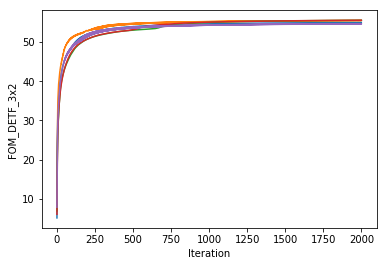

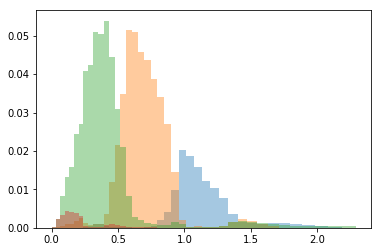

In [240]:
optimize_bins_new(zhistw, 4, ntrial=5, niter=2000, eta=1., gamma=0., decay=1.);

trial 1/5 iteration 1/2000 score 11.208
trial 1/5 iteration 250/2000 score 52.624
trial 1/5 iteration 500/2000 score 54.371
trial 1/5 iteration 750/2000 score 54.628
trial 1/5 iteration 1000/2000 score 54.738
trial 1/5 iteration 1250/2000 score 54.839
trial 1/5 iteration 1500/2000 score 54.883
trial 1/5 iteration 1750/2000 score 54.910
trial 1/5 iteration 2000/2000 score 54.944
trial 2/5 iteration 1/2000 score 9.780
trial 2/5 iteration 250/2000 score 52.224
trial 2/5 iteration 500/2000 score 53.923
trial 2/5 iteration 750/2000 score 54.282
trial 2/5 iteration 1000/2000 score 54.435
trial 2/5 iteration 1250/2000 score 54.493
trial 2/5 iteration 1500/2000 score 54.540
trial 2/5 iteration 1750/2000 score 54.577
trial 2/5 iteration 2000/2000 score 54.930
trial 3/5 iteration 1/2000 score 9.419
trial 3/5 iteration 250/2000 score 53.011
trial 3/5 iteration 500/2000 score 54.793
trial 3/5 iteration 750/2000 score 55.296
trial 3/5 iteration 1000/2000 score 55.428
trial 3/5 iteration 1250/2000 s

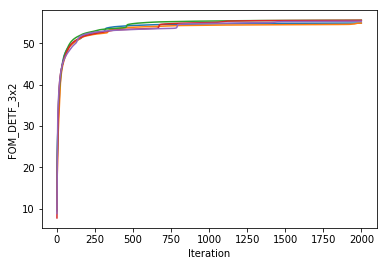

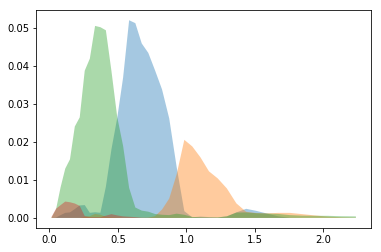

In [35]:
optimize_bins(zhistw, 4, ntrial=5, niter=2000, eta=1., gamma=0.);

trial 1/10 iteration 1/1000 score 4.165 max 4.165
trial 1/10 iteration 250/1000 score 19.929 max 19.929
trial 1/10 iteration 500/1000 score 20.234 max 20.234
trial 1/10 iteration 750/1000 score 20.399 max 20.399
trial 1/10 iteration 1000/1000 score 20.454 max 20.455
trial 2/10 iteration 1/1000 score 8.468 max 20.455
trial 2/10 iteration 250/1000 score 19.841 max 20.455
trial 2/10 iteration 500/1000 score 20.205 max 20.455
trial 2/10 iteration 750/1000 score 20.365 max 20.455
trial 2/10 iteration 1000/1000 score 20.433 max 20.455
trial 3/10 iteration 1/1000 score 3.925 max 20.455
trial 3/10 iteration 250/1000 score 19.770 max 20.455
trial 3/10 iteration 500/1000 score 20.201 max 20.455
trial 3/10 iteration 750/1000 score 20.360 max 20.455
trial 3/10 iteration 1000/1000 score 20.454 max 20.455
trial 4/10 iteration 1/1000 score 6.047 max 20.455
trial 4/10 iteration 250/1000 score 19.892 max 20.455
trial 4/10 iteration 500/1000 score 20.250 max 20.455
trial 4/10 iteration 750/1000 score 20

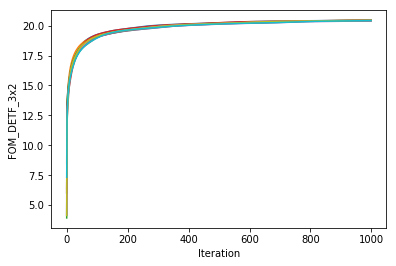

CPU times: user 2min 43s, sys: 3.36 s, total: 2min 46s
Wall time: 2min 36s


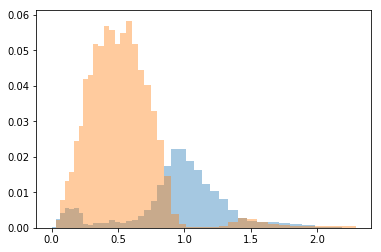

In [188]:
%time results = optimize_bins(zhistw, 2, niter=1000, ntrial=10)

trial 1/5 iteration 1/2000 score 12.315
trial 1/5 iteration 250/2000 score 65.981
trial 1/5 iteration 500/2000 score 67.097
trial 1/5 iteration 750/2000 score 67.434
trial 1/5 iteration 1000/2000 score 67.562
trial 1/5 iteration 1250/2000 score 67.667
trial 1/5 iteration 1500/2000 score 67.863
trial 1/5 iteration 1750/2000 score 67.948
trial 1/5 iteration 2000/2000 score 68.141
trial 2/5 iteration 1/2000 score 10.671
trial 2/5 iteration 250/2000 score 66.711
trial 2/5 iteration 500/2000 score 67.867
trial 2/5 iteration 750/2000 score 68.733
trial 2/5 iteration 1000/2000 score 68.912
trial 2/5 iteration 1250/2000 score 69.010
trial 2/5 iteration 1500/2000 score 69.084
trial 2/5 iteration 1750/2000 score 69.125
trial 2/5 iteration 2000/2000 score 69.160
trial 3/5 iteration 1/2000 score 9.424
trial 3/5 iteration 250/2000 score 63.574
trial 3/5 iteration 500/2000 score 66.019
trial 3/5 iteration 750/2000 score 66.452
trial 3/5 iteration 1000/2000 score 66.608
trial 3/5 iteration 1250/2000 

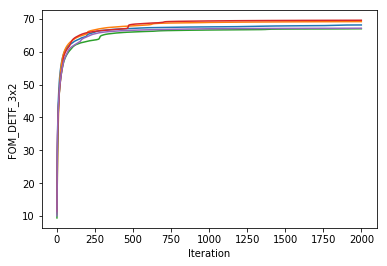

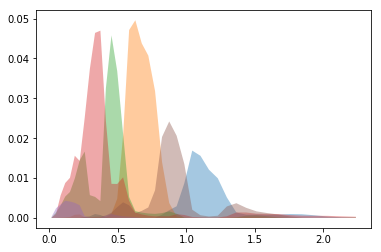

In [36]:
optimize_bins(zhistw, 6, ntrial=5, niter=2000, eta=1., gamma=0.);

trial 1/5 iteration 1/2000 score 12.781
trial 1/5 iteration 250/2000 score 75.366
trial 1/5 iteration 500/2000 score 76.852
trial 1/5 iteration 750/2000 score 78.273
trial 1/5 iteration 1000/2000 score 78.469
trial 1/5 iteration 1250/2000 score 78.574
trial 1/5 iteration 1500/2000 score 78.637
trial 1/5 iteration 1750/2000 score 78.704
trial 1/5 iteration 2000/2000 score 78.748
trial 2/5 iteration 1/2000 score 12.249
trial 2/5 iteration 250/2000 score 74.290
trial 2/5 iteration 500/2000 score 75.792
trial 2/5 iteration 750/2000 score 76.675
trial 2/5 iteration 1000/2000 score 76.908
trial 2/5 iteration 1250/2000 score 77.120
trial 2/5 iteration 1500/2000 score 77.382
trial 2/5 iteration 1750/2000 score 77.637
trial 2/5 iteration 2000/2000 score 77.696
trial 3/5 iteration 1/2000 score 12.470
trial 3/5 iteration 250/2000 score 72.491
trial 3/5 iteration 500/2000 score 73.506
trial 3/5 iteration 750/2000 score 75.209
trial 3/5 iteration 1000/2000 score 75.423
trial 3/5 iteration 1250/2000

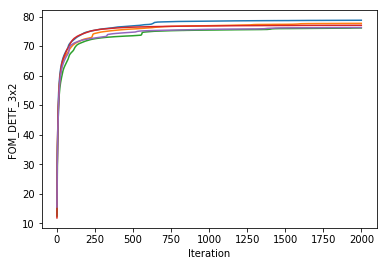

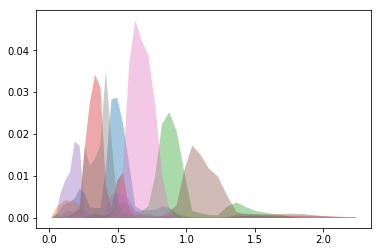

In [37]:
optimize_bins(zhistw, 8, ntrial=5, niter=2000, eta=1., gamma=0.);

In [38]:
optimize_bins(zhistw, 10, ntrial=5, niter=3000, eta=1., gamma=0.);

trial 1/5 iteration 1/3000 score 13.317
trial 1/5 iteration 250/3000 score 82.218
trial 1/5 iteration 500/3000 score 84.173
trial 1/5 iteration 750/3000 score 84.452
trial 1/5 iteration 1000/3000 score 84.640
trial 1/5 iteration 1250/3000 score 84.793
trial 1/5 iteration 1500/3000 score 84.896
trial 1/5 iteration 1750/3000 score 85.208
trial 1/5 iteration 2000/3000 score 85.253
trial 1/5 iteration 2250/3000 score 85.296
trial 1/5 iteration 2500/3000 score 85.326
trial 1/5 iteration 2750/3000 score 85.346
trial 1/5 iteration 3000/3000 score 85.365
trial 2/5 iteration 1/3000 score 12.062
trial 2/5 iteration 250/3000 score 80.508
trial 2/5 iteration 500/3000 score 82.832
trial 2/5 iteration 750/3000 score 83.643
trial 2/5 iteration 1000/3000 score 84.600
trial 2/5 iteration 1250/3000 score 84.766
trial 2/5 iteration 1500/3000 score 84.841
trial 2/5 iteration 1750/3000 score 85.620
trial 2/5 iteration 2000/3000 score 85.658
trial 2/5 iteration 2250/3000 score 85.682
trial 2/5 iteration 250

KeyboardInterrupt: 

trial 1/5 iteration 1/2000 score 8.085
trial 1/5 iteration 50/2000 score 17.426
trial 1/5 iteration 100/2000 score 18.397
trial 1/5 iteration 150/2000 score 18.860
trial 1/5 iteration 200/2000 score 19.180
trial 1/5 iteration 250/2000 score 19.444
trial 1/5 iteration 300/2000 score 19.610
trial 1/5 iteration 350/2000 score 19.738
trial 1/5 iteration 400/2000 score 19.846
trial 1/5 iteration 450/2000 score 19.923
trial 1/5 iteration 500/2000 score 19.985
trial 1/5 iteration 550/2000 score 20.040
trial 1/5 iteration 600/2000 score 20.088
trial 1/5 iteration 650/2000 score 20.130
trial 1/5 iteration 700/2000 score 20.163
trial 1/5 iteration 750/2000 score 20.189
trial 1/5 iteration 800/2000 score 20.215
trial 1/5 iteration 850/2000 score 20.239
trial 1/5 iteration 900/2000 score 20.280
trial 1/5 iteration 950/2000 score 20.333
trial 1/5 iteration 1000/2000 score 20.357
trial 1/5 iteration 1050/2000 score 20.376
trial 1/5 iteration 1100/2000 score 20.393
trial 1/5 iteration 1150/2000 score

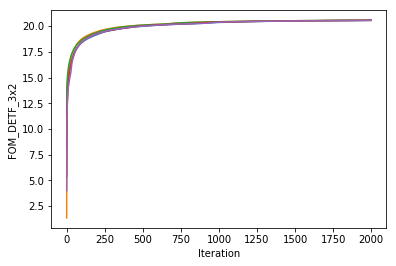

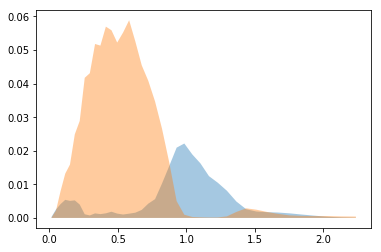

In [30]:
optimize_bins(zhistw4, 2, ntrial=5, niter=2000, eta=1.5, gamma=0.);

trial 1/5 iteration 1/1000 score 8.931
trial 1/5 iteration 50/1000 score 16.909
trial 1/5 iteration 100/1000 score 17.450
trial 1/5 iteration 150/1000 score 17.776
trial 1/5 iteration 200/1000 score 17.978
trial 1/5 iteration 250/1000 score 18.129
trial 1/5 iteration 300/1000 score 18.218
trial 1/5 iteration 350/1000 score 18.280
trial 1/5 iteration 400/1000 score 18.332
trial 1/5 iteration 450/1000 score 18.407
trial 1/5 iteration 500/1000 score 18.448
trial 1/5 iteration 550/1000 score 18.478
trial 1/5 iteration 600/1000 score 18.503
trial 1/5 iteration 650/1000 score 18.525
trial 1/5 iteration 700/1000 score 18.575
trial 1/5 iteration 750/1000 score 18.669
trial 1/5 iteration 800/1000 score 18.755
trial 1/5 iteration 850/1000 score 18.833
trial 1/5 iteration 900/1000 score 18.902
trial 1/5 iteration 950/1000 score 18.945
trial 1/5 iteration 1000/1000 score 18.970
trial 2/5 iteration 1/1000 score 4.733
trial 2/5 iteration 50/1000 score nan
trial 2/5 iteration 100/1000 score nan
trial

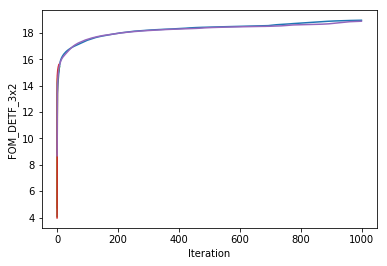

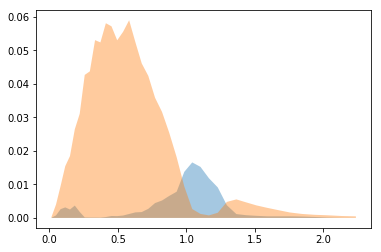

In [25]:
optimize_bins(zhistT, 2, ntrial=5, niter=1000, eta=2., gamma=0.5);

trial 1/5 iteration 1/1000 score 8.529
trial 1/5 iteration 50/1000 score 33.286
trial 1/5 iteration 100/1000 score 37.981
trial 1/5 iteration 150/1000 score 40.246
trial 1/5 iteration 200/1000 score 41.368
trial 1/5 iteration 250/1000 score 42.111
trial 1/5 iteration 300/1000 score 42.678
trial 1/5 iteration 350/1000 score 43.172
trial 1/5 iteration 400/1000 score 43.563
trial 1/5 iteration 450/1000 score 43.870
trial 1/5 iteration 500/1000 score 44.136
trial 1/5 iteration 550/1000 score 44.349
trial 1/5 iteration 600/1000 score 44.532
trial 1/5 iteration 650/1000 score 44.686
trial 1/5 iteration 700/1000 score 44.828
trial 1/5 iteration 750/1000 score 44.953
trial 1/5 iteration 800/1000 score 45.073
trial 1/5 iteration 850/1000 score 45.389
trial 1/5 iteration 900/1000 score 45.623
trial 1/5 iteration 950/1000 score 45.742
trial 1/5 iteration 1000/1000 score 45.826
trial 2/5 iteration 1/1000 score 9.418
trial 2/5 iteration 50/1000 score 24.043
trial 2/5 iteration 100/1000 score 35.838

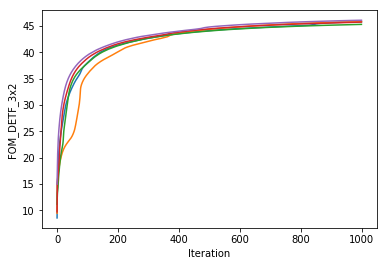

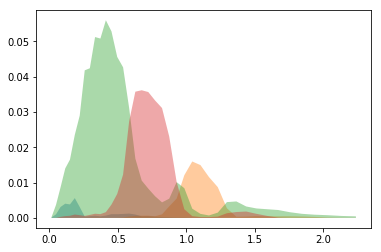

In [27]:
optimize_bins(zhistT, 4, ntrial=5, niter=1000, eta=1., gamma=0.1);

0 3.122199058532715
50 17.396455764770508
100 18.4249267578125
150 18.93551254272461
200 19.253820419311523
250 19.484947204589844
300 19.6508846282959
350 19.778343200683594
400 19.88817024230957
450 19.97054672241211
500 20.06418800354004
550 20.134557723999023
600 20.18043327331543
650 20.212865829467773
700 20.24028778076172
750 20.262876510620117
800 20.28203010559082
850 20.3049259185791
900 20.356212615966797
950 20.392414093017578
1000 20.411577224731445
1050 20.425966262817383
1100 20.43997573852539
1150 20.451248168945312
1200 20.462255477905273
1250 20.47226333618164
1300 20.48249053955078
1350 20.49242401123047
1400 20.49983024597168
1450 20.50786018371582
1500 20.51410484313965
1550 20.52092742919922
1600 20.527097702026367
1650 20.532989501953125
1700 20.539743423461914
1750 20.543399810791016
1800 20.548959732055664
1850 20.55400848388672
1900 20.55825424194336
1950 20.561084747314453
Max score: 20.565.


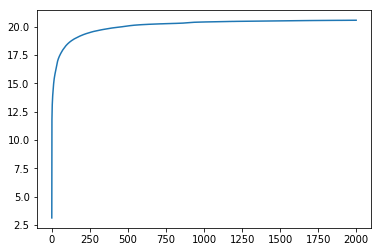

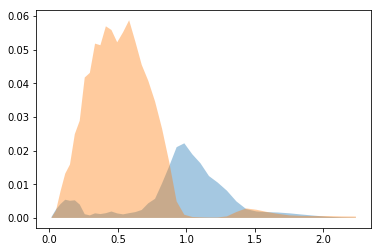

In [20]:
optimize_bins(zhistw4, 2, eta=1.5, niter=2000);

0 7.926904678344727
50 18.992572784423828
100 19.57083511352539
150 19.870691299438477
200 20.060819625854492
250 20.149843215942383
300 20.209636688232422
350 20.292253494262695
400 20.352537155151367
450 20.387746810913086
Max score: 20.415.


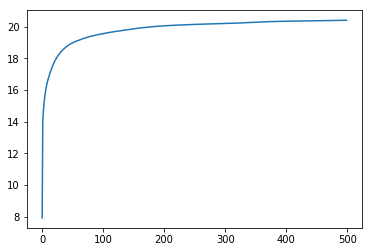

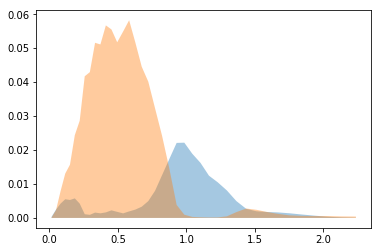

In [149]:
optimize_bins(zhistw, 2, eta=2, niter=500);

Assign bin labels to a sample based on optimized weights:

In [67]:
def get_labels(z, w, seed=1):
    nds = len(zds) - 1
    gen = np.random.RandomState(seed)
    # Assign each redshift to an input redshift bin.
    idx = np.clip(np.digitize(z, zds) - 1, 0, nds - 1)
    # Calculate the CDF for mapping each input bin to output bins.
    cdf = np.cumsum(w, axis=0)
    cdf /= cdf[-1]
    # Loop over input bins to assign output bins sampled from the CDF.
    labels = np.empty(len(z), int)
    for i in range(nds):
        sel = idx == i
        nsel = np.count_nonzero(sel)
        u = gen.uniform(size=nsel)
        labels[sel] = np.searchsorted(cdf[:, i], u)
    return labels
    
labels4 = get_labels(zbuz, wbest4)

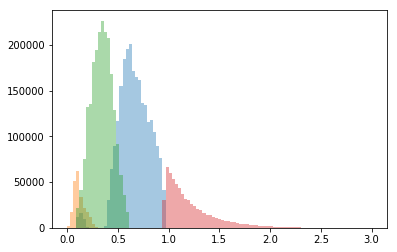

In [68]:
def plot_labels(z, labels):
    nbin = labels.max() + 1
    for i in range(nbin):
        sel = labels == i
        plt.hist(z[sel], bins=np.linspace(0, 3, 100), histtype='stepfilled', alpha=0.4)
        
plot_labels(zbuz, labels4)

In [69]:
np.save('buzzard_labels4.npy', labels4.astype(np.uint8))

In [70]:
ls -lh *.npy

-rw-rw-r-- 1 dkirkby dkirkby 5.2M Sep  3 07:41 buzzard_labels4.npy
-rw-rw-r-- 1 dkirkby dkirkby 8.3M Sep  2 11:50 dc2-labels.npy


## Nbins = 2

0 7.3986687660217285
50 18.784330368041992
100 19.653308868408203
150 19.987346649169922
200 20.19344711303711
250 20.293758392333984
300 20.33831024169922
350 20.36216926574707
400 20.381399154663086
450 20.39472007751465


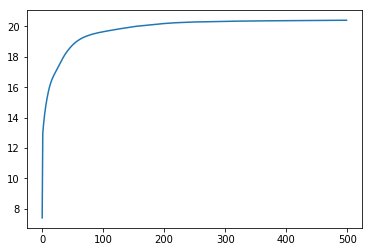

Max score: 20.409.


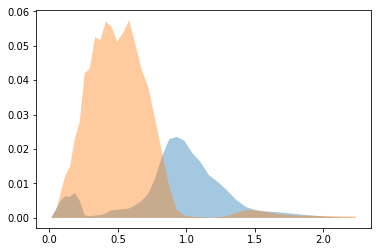

In [118]:
optimize_bins(zhistn, 2, eta=1., niter=500);

0 11.72891616821289
50 53.566261291503906
100 56.76713562011719
150 57.63714599609375
200 58.1176872253418
250 58.437564849853516
300 59.57559585571289
350 59.99556350708008
400 60.24839401245117
450 60.62715530395508


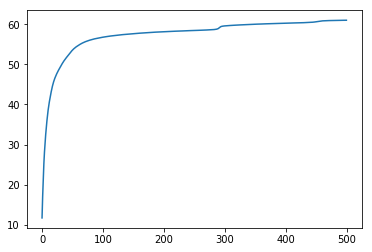

Max score: 60.984.


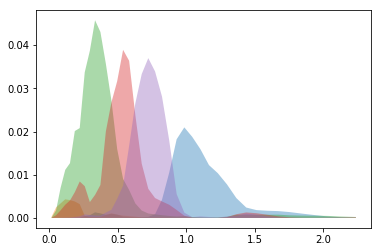

In [120]:
optimize_bins(zhistw, nbin=5, eta=1., niter=500);

0 11.476663589477539
50 46.96494674682617
100 50.201290130615234
150 51.214111328125
200 51.70956802368164
250 52.00373077392578
300 52.21335220336914
350 53.21934127807617
400 53.52640151977539
450 53.7055549621582
500 53.82396697998047
550 53.910335540771484
600 53.97649002075195
650 54.03995132446289
700 54.08826446533203
750 54.12969970703125
800 54.162689208984375
850 54.215980529785156
900 54.31020736694336
950 54.34477615356445


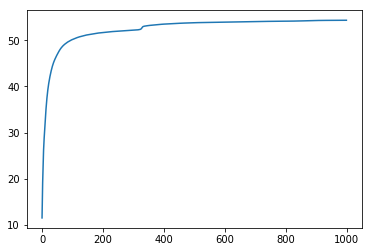

Max score: 54.367.


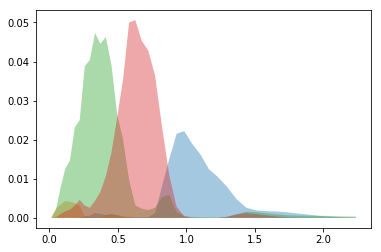

In [122]:
optimize_bins(zhistw, nbin=4, eta=1., niter=1000);

0 12.75029468536377
50 56.79963684082031
100 62.852474212646484
150 69.93870544433594
200 71.03986358642578
250 71.5235595703125
300 71.83009338378906
350 72.0654296875
400 72.30609130859375
450 72.47432708740234
500 72.61727142333984
550 72.8478012084961
600 73.02984619140625
650 73.1159439086914
700 73.19467163085938
750 73.32044219970703
800 73.48956298828125
850 73.55175018310547
900 73.58354949951172
950 73.61466217041016
1000 73.64636993408203
1050 73.80606079101562
1100 73.86512756347656
1150 73.89683532714844
1200 73.91090393066406
1250 73.92639923095703
1300 73.9473876953125
1350 73.96749114990234
1400 73.97801208496094
1450 73.99661254882812
1500 74.01612091064453
1550 74.01787567138672
1600 74.02864074707031
1650 74.03841400146484
1700 74.05205535888672
1750 74.05503845214844
1800 74.05911254882812
1850 74.064697265625
1900 74.07462310791016
1950 74.07882690429688


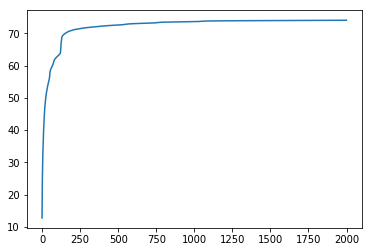

Max score: 74.091.


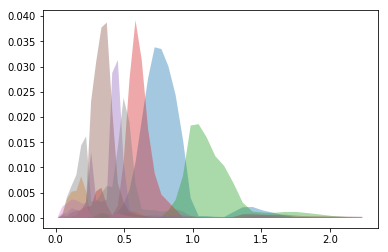

In [123]:
optimize_bins(zhistw, nbin=8, eta=1., niter=2000);

## Direct Optimization of the True Reshift Binning

In [87]:
np.save('dc2-labels.npy', labels.astype(np.uint8))

In [88]:
!ls -lh dc2-labels.npy

-rw-rw-r-- 1 dkirkby dkirkby 8.3M Sep  2 11:50 dc2-labels.npy


0 2.856764793395996
50 38.481788635253906


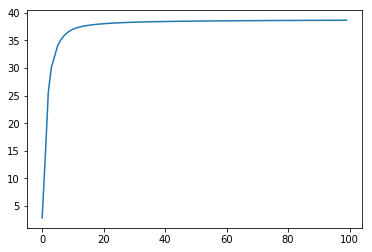

Max score: 38.635.


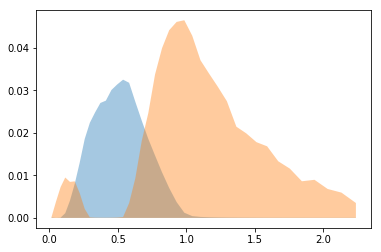

In [105]:
optimize_truez(dndz_dc2, nbin=2, eta=1., niter=100);

0 3.2000186443328857
50 21.976913452148438


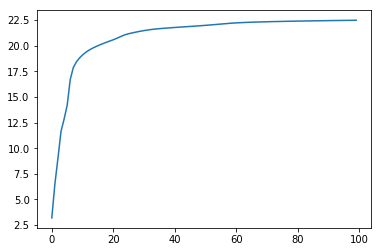

Max score: 22.474.


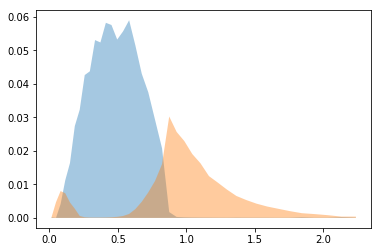

In [57]:
optimize_weights(dndz_buz, nbin=2, eta=1., niter=100);

0 3.2018086910247803
50 21.977750778198242


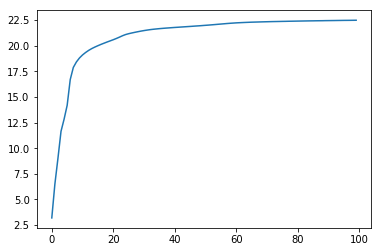

Max score: 22.472.
CPU times: user 3.55 s, sys: 135 ms, total: 3.69 s
Wall time: 3.58 s


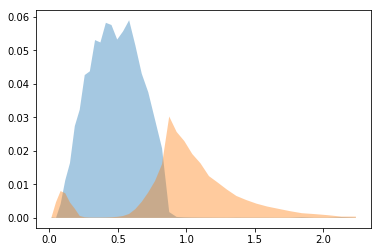

In [28]:
%time w2, m2 = optimize_weights(nbin=2, eta=1., niter=100)

0 6.0063157081604
50 45.33053207397461


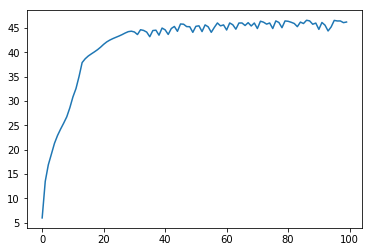

Max score: 46.574.
CPU times: user 7.89 s, sys: 71 ms, total: 7.97 s
Wall time: 7.84 s


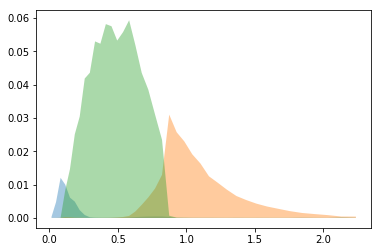

In [29]:
%time w3, m3 = optimize_weights(nbin=3, eta=1., niter=100)

0 8.490499496459961
50 58.03609085083008
100 62.18034744262695
150 62.82968521118164
200 63.00864028930664
250 63.640865325927734
300 65.184814453125
350 64.04039001464844
400 65.45266723632812
450 65.64655303955078


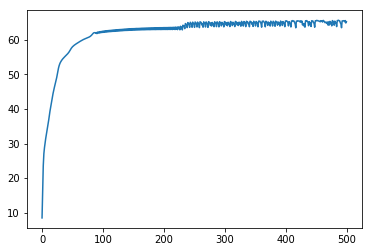

Max score: 65.698.
CPU times: user 1min 17s, sys: 149 ms, total: 1min 17s
Wall time: 1min 17s


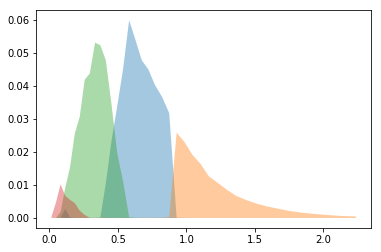

In [32]:
%time w4, m4 = optimize_weights(nbin=4, eta=0.5, niter=500)

0 9.764266967773438
50 62.84239959716797
100 70.74346923828125
150 73.1115493774414
200 72.82343292236328
250 74.05504608154297
300 73.94087982177734
350 74.84740447998047
400 75.19644165039062
450 75.52391052246094


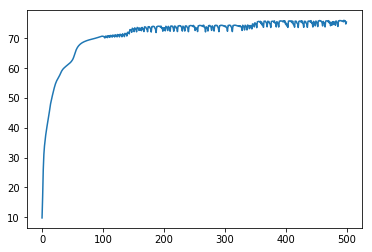

Max score: 76.101.
CPU times: user 2min 56s, sys: 518 ms, total: 2min 57s
Wall time: 2min 57s


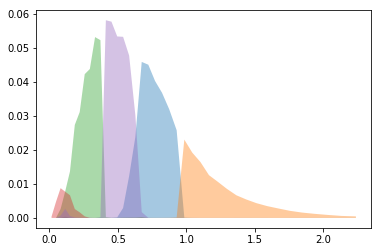

In [33]:
%time w5, m5 = optimize_weights(nbin=5, eta=0.5, niter=500)

0 13.888534545898438
50 68.62844848632812
100 75.19667053222656
150 76.26265716552734
200 77.2719497680664
250 78.62643432617188
300 77.6267318725586
350 79.51612091064453
400 79.62677764892578
450 77.9648208618164


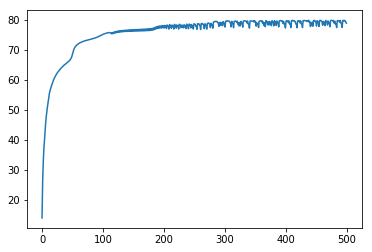

Max score: 79.900.
CPU times: user 5min 49s, sys: 970 ms, total: 5min 50s
Wall time: 5min 50s


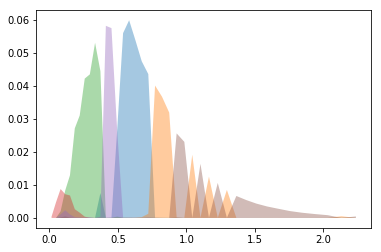

In [34]:
%time w6, m6 = optimize_weights(nbin=6, eta=0.5, niter=500)

0 54.26852035522461
50 75.6591567993164
100 78.65259552001953
150 79.76007080078125


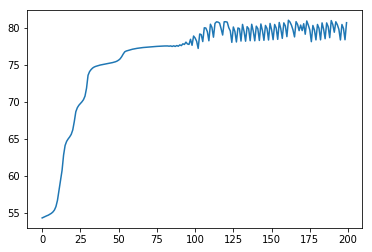

CPU times: user 2min 18s, sys: 616 ms, total: 2min 19s
Wall time: 2min 19s


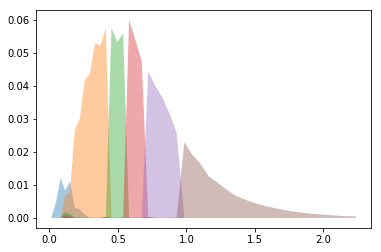

In [88]:
%time w6, m6 = method2_optimize(nbin=6, eta=0.7, niter=200)

0 16.436464309692383
50 84.64531707763672
100 86.92375183105469
150 88.50049591064453
200 88.01998138427734
250 88.68807983398438


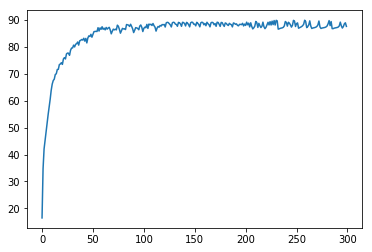

Max score: 89.942.
CPU times: user 6min 28s, sys: 1.22 s, total: 6min 29s
Wall time: 6min 29s


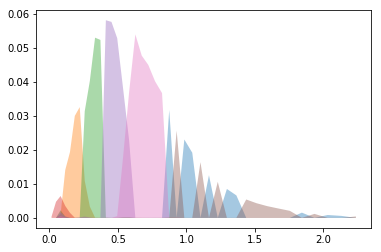

In [35]:
%time w7, m7 = optimize_weights(nbin=7, eta=1., niter=300)

0 25.680673599243164
50 144.82473754882812
100 145.5882110595703
150 147.18321228027344


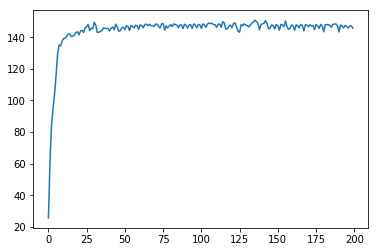

Max score: 150.726.
CPU times: user 6min 59s, sys: 627 ms, total: 6min 59s
Wall time: 6min 59s


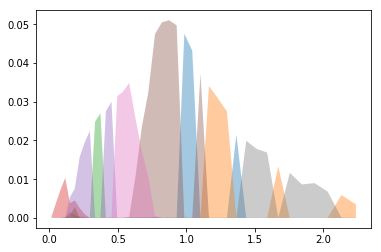

In [91]:
%time w8dc2, m8dc2 = optimize_weights(dndz_dc2, nbin=8, eta=1., niter=200)

0 22.10607147216797
50 89.36427307128906
100 96.18096923828125
150 99.5829086303711


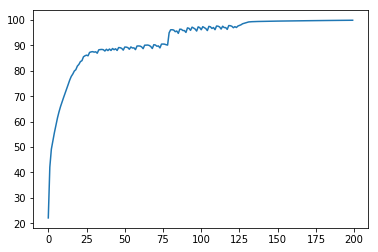

Max score: 99.917.
CPU times: user 6min 57s, sys: 866 ms, total: 6min 58s
Wall time: 6min 58s


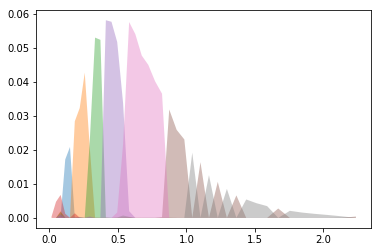

In [36]:
%time w8, m8 = optimize_weights(nbin=8, eta=1., niter=200)

0 24.794164657592773
50 94.96270751953125
100 96.4365005493164
150 96.34480285644531


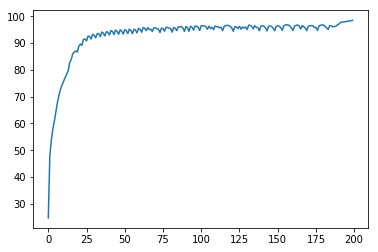

Max score: 98.481.
CPU times: user 10min 56s, sys: 1.28 s, total: 10min 57s
Wall time: 10min 57s


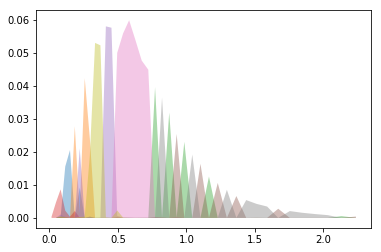

In [37]:
%time w9, m9 = optimize_weights(nbin=9, eta=1., niter=200)